In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lightmooccubex/relations/course-teacher.txt
/kaggle/input/lightmooccubex/relations/concept-comment.txt
/kaggle/input/lightmooccubex/relations/user-video.json
/kaggle/input/lightmooccubex/relations/course-comment.txt
/kaggle/input/lightmooccubex/relations/concept-problem.txt
/kaggle/input/lightmooccubex/relations/user-reply.txt
/kaggle/input/lightmooccubex/relations/concept-video.txt
/kaggle/input/lightmooccubex/relations/course-school.txt
/kaggle/input/lightmooccubex/relations/user-comment.txt
/kaggle/input/lightmooccubex/relations/exercise-problem.txt
/kaggle/input/lightmooccubex/relations/concept-paper.txt
/kaggle/input/lightmooccubex/relations/reply-reply.txt
/kaggle/input/lightmooccubex/relations/course-field.json
/kaggle/input/lightmooccubex/relations/video_id-ccid.txt
/kaggle/input/lightmooccubex/relations/concept-reply.json
/kaggle/input/lightmooccubex/relations/comment-reply.txt
/kaggle/input/lightmooccubex/relations/concept-other.txt
/kaggle/input/lightmooccubex/

In [2]:
import polars as pl
from tqdm import tqdm
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy

# Import data

In [3]:
comment_df = pl.read_ndjson('/kaggle/input/lightmooccubex/entities/comment.json')
comment_df = comment_df.rename({"id": "comment_id"})
comment_df.head()

comment_id,user_id,text,resource_id,create_time
str,i64,str,str,str
"""Cm_1""",10030806,"""测试评论""",null,"""2019-08-05 12:55:27"""
"""Cm_4""",1705400,"""嗯嗯""",null,"""2019-08-05 16:56:43"""
"""Cm_5""",10031537,"""是的，我也看不到""",null,"""2019-08-07 21:05:38"""
"""Cm_7""",10031502,"""大师傅as""",null,"""2019-08-09 13:06:06"""
"""Cm_12""",10031397,"""点赞""",null,"""2019-08-09 16:38:56"""


In [4]:
reply_df = pl.read_ndjson('/kaggle/input/lightmooccubex/entities/reply.json')
reply_df = reply_df.rename({"id": "reply_id"})
reply_df.head()

reply_id,user_id,text,create_time
str,str,str,str
"""Rp_1""","""U_10030806""","""测试回复""","""2019-08-05 12:55:54"""
"""Rp_2""","""U_10031397""","""赞""","""2019-08-09 16:39:06"""
"""Rp_3""","""U_10031531""","""好喜欢""","""2019-08-10 22:39:35"""
"""Rp_4""","""U_10031508""","""你也好棒""","""2019-08-12 14:43:34"""
"""Rp_5""","""U_10031508""","""嗯对""","""2019-08-12 14:44:51"""


In [5]:
user_df = pl.read_ndjson('/kaggle/input/lightmooccubex/entities/user.json')
user_df = user_df.rename({"id": "user_id"})
user_df.head()

user_id,name,gender,school,year_of_birth,course_order,enroll_time
str,str,i64,str,i64,list[i64],list[str]
"""U_22""","""我""",0,"""""",2015,"[682129, 2294668]","[""2019-10-12 10:28:02"", ""2020-11-21 14:03:28""]"
"""U_24""","""王帅国""",1,"""清华大学""",6558,"[597214, 605512, … 2229905]","[""2019-05-20 16:06:48"", ""2019-05-24 19:34:43"", … ""2020-11-21 11:38:57""]"
"""U_25""","""王帅国""",0,"""清华大学""",null,[1903985],"[""2020-08-07 18:59:13""]"
"""U_53""","""于歆杰""",1,"""清华大学""",1973,"[696679, 1704639, … 1794464]","[""2020-03-01 21:24:30"", ""2020-03-12 16:17:02"", … ""2020-06-18 18:47:15""]"
"""U_54""","""马昱春""",2,"""清华大学""",null,"[682442, 682164, … 1906706]","[""2019-10-09 02:17:49"", ""2019-11-08 00:49:03"", … ""2020-07-20 11:27:28""]"


In [6]:
course_comment = pd.read_csv('/kaggle/input/lightmooccubex/relations/course-comment.txt', 
                             sep="\t", header=None, names=["course_id", "comment_id"])
course_comment.head()

,course_id,comment_id
0,C_597284,Cm_4
1,C_597334,Cm_61
2,C_682246,Cm_74
3,C_697602,Cm_83
4,C_605983,Cm_88


In [7]:
comment_reply = pd.read_csv('/kaggle/input/lightmooccubex/relations/comment-reply.txt',
                             sep="\t", header=None, names=["comment_id", "reply_id"])

comment_reply.head()

,comment_id,reply_id
0,Cm_1,Rp_1
1,Cm_12,Rp_2
2,Cm_24,Rp_3
3,Cm_43,Rp_4
4,Cm_44,Rp_5


# EDA cơ bản

In [8]:
reply_pd = reply_df.to_pandas()
reply_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331011 entries, 0 to 331010
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   reply_id     331011 non-null  object
 1   user_id      331011 non-null  object
 2   text         331011 non-null  object
 3   create_time  331011 non-null  object
dtypes: object(4)
memory usage: 10.1+ MB


In [9]:
comment_df = comment_df[['comment_id',	'user_id', 'text', 'create_time']]

In [10]:
comment_pd = comment_df.to_pandas()
comment_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8395141 entries, 0 to 8395140
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   comment_id   object
 1   user_id      int64 
 2   text         object
 3   create_time  object
dtypes: int64(1), object(3)
memory usage: 256.2+ MB


In [11]:
user_pd = user_df.to_pandas()
user_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3330294 entries, 0 to 3330293
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   name           object 
 2   gender         float64
 3   school         object 
 4   year_of_birth  float64
 5   course_order   object 
 6   enroll_time    object 
dtypes: float64(2), object(5)
memory usage: 177.9+ MB


In [12]:
reply_counts = comment_reply["comment_id"].value_counts()
multiple_replies = reply_counts[reply_counts > 1]

print(multiple_replies)

comment_id
Cm_7297425     499
Cm_13936683    331
Cm_7297413     330
Cm_4643165     323
Cm_6654880     279
              ... 
Cm_656602        2
Cm_15619133      2
Cm_6912686       2
Cm_3198473       2
Cm_13747811      2
Name: count, Length: 30980, dtype: int64


# Gộp các file

In [13]:
comment_data = course_comment.merge(comment_pd, on="comment_id", how="right")
comment_data.head(10)

,course_id,comment_id,user_id,text,create_time
0,NaN,Cm_1,10030806,测试评论,2019-08-05 12:55:27
1,C_597284,Cm_4,1705400,嗯嗯,2019-08-05 16:56:43
2,NaN,Cm_5,10031537,是的，我也看不到,2019-08-07 21:05:38
3,NaN,Cm_7,10031502,大师傅as,2019-08-09 13:06:06
4,NaN,Cm_12,10031397,点赞,2019-08-09 16:38:56
5,NaN,Cm_13,10031397,好滴,2019-08-09 17:29:01
6,NaN,Cm_14,10031528,很好，赞一个,2019-08-09 17:41:54
7,NaN,Cm_16,10031531,老师好,2019-08-09 17:44:31
8,NaN,Cm_19,10031356,好的,2019-08-09 18:20:05
9,NaN,Cm_20,10031356,好的,2019-08-09 18:20:07


In [14]:
comment_data.isnull().sum()

course_id      1786561
comment_id           0
user_id              0
text                 0
create_time          0
dtype: int64

In [15]:
# Chuyển đổi thứ tự cột
comment_user = comment_data[['comment_id', 'user_id', 'course_id', 'text', 'create_time']]
comment_user['user_id'] = comment_user['user_id'].apply(lambda x: f"U_{x}")
comment_user.dropna(subset=['course_id', 'user_id'], inplace=True)

comment_user.head()

,comment_id,user_id,course_id,text,create_time
1,Cm_4,U_1705400,C_597284,嗯嗯,2019-08-05 16:56:43
28,Cm_61,U_105,C_597334,老师好,2019-08-15 16:25:14
31,Cm_74,U_9520252,C_682246,这个评价的功能太隐蔽了,2019-08-23 11:25:35
33,Cm_83,U_361418,C_697602,评论,2019-09-02 15:37:18
34,Cm_88,U_6875014,C_605983,测试,2019-09-03 10:35:27


In [16]:
user = user_pd
user["course_enroll_map"] = user.apply(
    lambda row: dict(zip(row["course_order"], row["enroll_time"])), axis=1
)

In [17]:
comment_user = comment_user.merge(user[['user_id', 'course_enroll_map']], on='user_id', how='left')

In [18]:
comment_user.isnull().sum()

comment_id                0
user_id                   0
course_id                 0
text                      0
create_time               0
course_enroll_map    275655
dtype: int64

In [19]:
comment_user["course_id_clean"] = comment_user["course_id"].str.replace("C_", "", regex=False)  

In [20]:
comment_user["course_id_clean"] = comment_user["course_id_clean"].astype(int)

In [21]:
comment_user.head()

,comment_id,user_id,course_id,text,create_time,course_enroll_map,course_id_clean
0,Cm_4,U_1705400,C_597284,嗯嗯,2019-08-05 16:56:43,"{375779: '2019-01-25 18:08:47', 375775: '2019-...",597284
1,Cm_61,U_105,C_597334,老师好,2019-08-15 16:25:14,"{609639: '2019-06-04 17:03:21', 597334: '2019-...",597334
2,Cm_74,U_9520252,C_682246,这个评价的功能太隐蔽了,2019-08-23 11:25:35,"{679265: '2019-08-20 15:38:03', 676946: '2019-...",682246
3,Cm_83,U_361418,C_697602,评论,2019-09-02 15:37:18,"{375779: '2019-01-25 18:00:03', 375775: '2019-...",697602
4,Cm_88,U_6875014,C_605983,测试,2019-09-03 10:35:27,"{375775: '2019-03-21 11:23:24', 375778: '2019-...",605983


In [22]:
comment_user["enroll_time"] = comment_user.apply(
    lambda row: row["course_enroll_map"].get(row["course_id_clean"], None) 
    if isinstance(row["course_enroll_map"], dict) else None, axis=1
)

In [23]:
comment_user.drop(columns=["course_enroll_map",'course_id_clean'], inplace=True)

In [24]:
comment_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6608580 entries, 0 to 6608579
Data columns (total 6 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   comment_id   object
 1   user_id      object
 2   course_id    object
 3   text         object
 4   create_time  object
 5   enroll_time  object
dtypes: object(6)
memory usage: 302.5+ MB


In [25]:
print("Số lượng khóa học không có thời gian đăng ký trên tổng số khóa học:",comment_user['enroll_time'].isnull().sum()/len(comment_user))

Số lượng khóa học không có thời gian đăng ký trên tổng số khóa học: 0.04180686319905335


In [26]:
comment_user.dropna(subset=['enroll_time'], inplace=True)
comment = comment_user
comment.head()

,comment_id,user_id,course_id,text,create_time,enroll_time
0,Cm_4,U_1705400,C_597284,嗯嗯,2019-08-05 16:56:43,2019-07-30 14:53:48
1,Cm_61,U_105,C_597334,老师好,2019-08-15 16:25:14,2019-08-15 16:19:54
2,Cm_74,U_9520252,C_682246,这个评价的功能太隐蔽了,2019-08-23 11:25:35,2019-08-23 11:23:23
3,Cm_83,U_361418,C_697602,评论,2019-09-02 15:37:18,2019-09-02 15:31:39
4,Cm_88,U_6875014,C_605983,测试,2019-09-03 10:35:27,2019-09-03 10:35:28


In [27]:
# Chuyển đổi cột thời gian sang kiểu datetime
comment['create_time'] = pd.to_datetime(comment['create_time'], errors='coerce')
comment['enroll_time'] = pd.to_datetime(comment['enroll_time'], errors='coerce')

In [28]:
# Tính khoảng thời gian từ enroll_time đến create_time
comment['days_since_enroll'] = (comment['create_time'] - comment['enroll_time']).dt.days

In [29]:
import re

def count_words(text):
    text = str(text).strip()  # Đảm bảo dữ liệu không bị lỗi None hoặc NaN
    
    # Nếu chứa ký tự CJK (tiếng Trung, Nhật, Hàn)
    if re.search(r'[\u4e00-\u9fff\u3040-\u30ff\uac00-\ud7af]', text):
        # Loại bỏ dấu câu trước khi đếm ký tự
        text = re.sub(r'[，。！？、…—「」『』（）【】《》〈〉~]', '', text)
        return len(text)  # Đếm số ký tự còn lại
    
    else:
        # Đếm số từ tiếng Anh
        return len(re.findall(r'\b\w+\b', text))

# Áp dụng vào DataFrame
comment['num_words_rep'] = comment['text'].apply(count_words)

# Kiểm tra kết quả
comment.head(10)

,comment_id,user_id,course_id,text,create_time,enroll_time,days_since_enroll,num_words_rep
0,Cm_4,U_1705400,C_597284,嗯嗯,2019-08-05 16:56:43,2019-07-30 14:53:48,6,2
1,Cm_61,U_105,C_597334,老师好,2019-08-15 16:25:14,2019-08-15 16:19:54,0,3
2,Cm_74,U_9520252,C_682246,这个评价的功能太隐蔽了,2019-08-23 11:25:35,2019-08-23 11:23:23,0,11
3,Cm_83,U_361418,C_697602,评论,2019-09-02 15:37:18,2019-09-02 15:31:39,0,2
4,Cm_88,U_6875014,C_605983,测试,2019-09-03 10:35:27,2019-09-03 10:35:28,-1,2
5,Cm_89,U_2005701,C_605512,讨论,2019-09-03 10:40:38,2019-06-24 16:12:38,70,2
6,Cm_92,U_6875014,C_605983,厉害了,2019-09-03 20:15:13,2019-09-03 10:35:28,0,3
7,Cm_93,U_6875014,C_605983,厉害了,2019-09-03 20:15:14,2019-09-03 10:35:28,0,3
8,Cm_100,U_11731,C_696700,是根深蒂固,2019-09-05 14:50:03,2019-09-05 14:07:20,0,5
9,Cm_101,U_11731,C_696700,大发的说法,2019-09-05 14:50:06,2019-09-05 14:07:20,0,5


In [30]:
# Lọc bỏ những dòng có thời gian bình luận nhỏ hơn hoặc bằng thời gian đăng ký
comment = comment[comment['create_time'] > comment['enroll_time']]

comment.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6331256 entries, 0 to 6608579
Data columns (total 8 columns):
 #   Column             Dtype         
---  ------             -----         
 0   comment_id         object        
 1   user_id            object        
 2   course_id          object        
 3   text               object        
 4   create_time        datetime64[ns]
 5   enroll_time        datetime64[ns]
 6   days_since_enroll  int64         
 7   num_words_rep      int64         
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 434.7+ MB


In [31]:
comment.to_csv("comment_C.csv", index = False)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


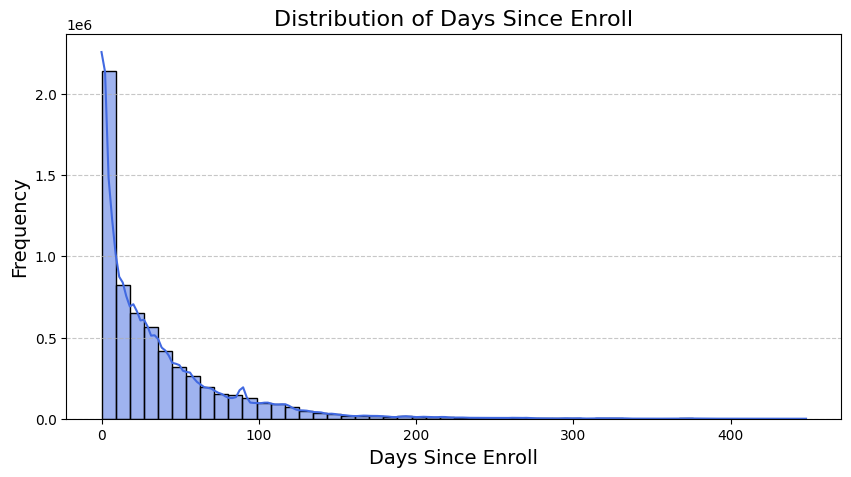

In [32]:
plt.figure(figsize=(10, 5))
sns.histplot(comment['days_since_enroll'], bins=50, kde=True, color='royalblue')
plt.xlabel('Days Since Enroll', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Days Since Enroll', fontsize=16)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Phase 1

In [33]:
Phase1_cmt = comment[comment['days_since_enroll'] <= 14]

In [34]:
Phase1_cmt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2733459 entries, 0 to 6608566
Data columns (total 8 columns):
 #   Column             Dtype         
---  ------             -----         
 0   comment_id         object        
 1   user_id            object        
 2   course_id          object        
 3   text               object        
 4   create_time        datetime64[ns]
 5   enroll_time        datetime64[ns]
 6   days_since_enroll  int64         
 7   num_words_rep      int64         
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 187.7+ MB


In [35]:
# Tính tổng số chữ phản hồi của user trong phase 1
word_count_phase1 = Phase1_cmt.groupby(['user_id', 'course_id'])['num_words_rep'].sum().reset_index(name='total_words_phase1')

# Đếm số lượng phản hồi trong phase 1
comment_count_phase1 = Phase1_cmt.groupby(['user_id', 'course_id']).size().reset_index(name='comment_count_phase1')

result_phase1 = pd.merge(comment_count_phase1, word_count_phase1, on=['user_id', 'course_id'], how='outer')
print(result_phase1)

          user_id  course_id  comment_count_phase1  total_words_phase1
0       U_1000902   C_697821                     1                   2
1       U_1001314  C_1779421                     3                  43
2         U_10015  C_1729417                     1                   8
3       U_1001600   C_694149                     1                   2
4       U_1001625   C_735164                     1                   8
...           ...        ...                   ...                 ...
488010   U_998479   C_694149                     1                   2
488011   U_998604   C_934535                     5                 324
488012   U_999111   C_760442                     1                 309
488013   U_999328   C_694149                     2                  22
488014   U_999821   C_881485                     1                   7

[488015 rows x 4 columns]


In [36]:
# Bước 1: Sắp xếp dữ liệu theo user_id, course_id, và create_time
Phase1_cmt = Phase1_cmt.sort_values(by=['user_id', 'course_id', 'create_time'])

# Bước 2: Xác định khoảng thời gian (bins)
def assign_time_bin(timestamp):
    """
    Chia ngày thành 48 khoảng thời gian (mỗi khoảng 30 phút) và gán bin tương ứng.
    """
    return (timestamp.hour * 60 + timestamp.minute) // 30

Phase1_cmt['time_bin'] = Phase1_cmt['create_time'].apply(assign_time_bin)

# Bước 3: Đếm số lượng comment trong mỗi khoảng thời gian
time_bin_counts1 = Phase1_cmt.groupby(['user_id', 'course_id', 'time_bin']).size().reset_index(name='count')

# Bước 4: Tính tổng số comment của mỗi user trong từng khóa học
total_comments1 = Phase1_cmt.groupby(['user_id', 'course_id']).size().reset_index(name='total_count')

# Gộp dữ liệu để tính xác suất
time_bin_counts1 = time_bin_counts1.merge(total_comments1, on=['user_id', 'course_id'], how='left')

# Bước 5: Tính xác suất xuất hiện của mỗi bin
time_bin_counts1['probability'] = time_bin_counts1['count'] / time_bin_counts1['total_count']

# Bước 6: Tính entropy theo công thức Shannon entropy
def calculate_entropy(probabilities):
    """
    Tính entropy theo công thức Shannon entropy.
    Loại bỏ giá trị xác suất bằng 0 để tránh lỗi log(0).
    """
    probabilities = probabilities[probabilities > 0]  # Loại bỏ giá trị 0
    return -np.sum(probabilities * np.log(probabilities)) if len(probabilities) > 1 else 0

entropy_values_phase1 = (
    time_bin_counts1.groupby(['user_id', 'course_id'])['probability']
    .apply(lambda x: calculate_entropy(x.values))
    .reset_index(name='entropy_time_comment_phase1')
)

# Hiển thị kết quả
print(entropy_values_phase1.head())

     user_id  course_id  entropy_time_comment_phase1
0  U_1000902   C_697821                     0.000000
1  U_1001314  C_1779421                     0.636514
2    U_10015  C_1729417                     0.000000
3  U_1001600   C_694149                     0.000000
4  U_1001625   C_735164                     0.000000


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


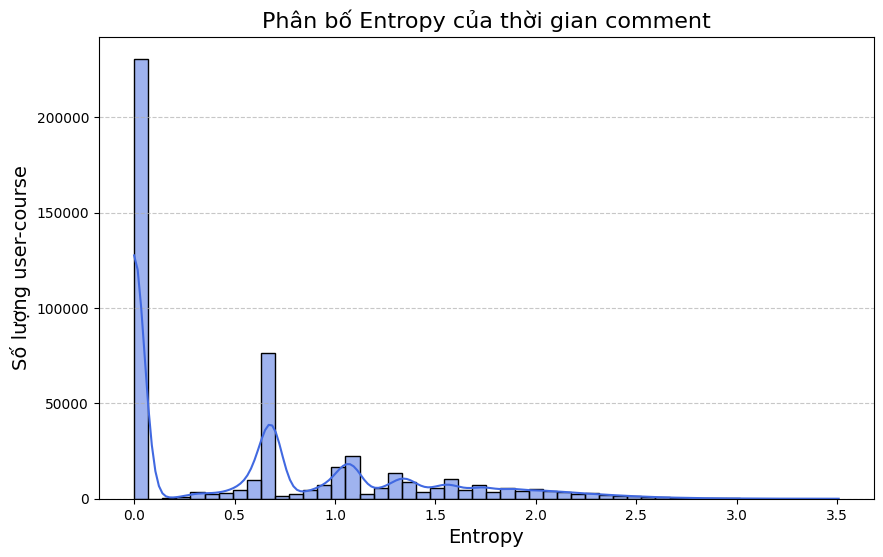

In [37]:
# Vẽ biểu đồ phân bố entropy
plt.figure(figsize=(10, 6))
sns.histplot(entropy_values_phase1["entropy_time_comment_phase1"], bins=50, kde=True, color="royalblue")

# Định dạng biểu đồ
plt.xlabel("Entropy", fontsize=14)
plt.ylabel("Số lượng user-course", fontsize=14)
plt.title("Phân bố Entropy của thời gian comment", fontsize=16)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Hiển thị biểu đồ
plt.show()

In [38]:
Phase1_comment = result_phase1.merge(entropy_values_phase1, on=['user_id', 'course_id'], how='outer')

# Nếu một số user-course không có entropy, điền giá trị mặc định là 0
Phase1_comment['entropy_time_comment_phase1'] = Phase1_comment['entropy_time_comment_phase1'].fillna(0)

print(Phase1_comment.head())

     user_id  course_id  comment_count_phase1  total_words_phase1  \
0  U_1000902   C_697821                     1                   2   
1  U_1001314  C_1779421                     3                  43   
2    U_10015  C_1729417                     1                   8   
3  U_1001600   C_694149                     1                   2   
4  U_1001625   C_735164                     1                   8   

   entropy_time_comment_phase1  
0                     0.000000  
1                     0.636514  
2                     0.000000  
3                     0.000000  
4                     0.000000  


# Phase 2

In [39]:
Phase2_cmt = comment[(comment['days_since_enroll'] > 14) & (comment['days_since_enroll'] <= 28)]

In [40]:
Phase2_cmt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1042023 entries, 121 to 6608567
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   comment_id         1042023 non-null  object        
 1   user_id            1042023 non-null  object        
 2   course_id          1042023 non-null  object        
 3   text               1042023 non-null  object        
 4   create_time        1042023 non-null  datetime64[ns]
 5   enroll_time        1042023 non-null  datetime64[ns]
 6   days_since_enroll  1042023 non-null  int64         
 7   num_words_rep      1042023 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 71.6+ MB


In [41]:
# Tính tổng số chữ phản hồi của user trong phase 2
word_count_phase2 = Phase2_cmt.groupby(['user_id', 'course_id'])['num_words_rep'].sum().reset_index(name='total_words_phase2')

# Đếm số lượng phản hồi trong phase 2
comment_count_phase2 = Phase2_cmt.groupby(['user_id', 'course_id']).size().reset_index(name='comment_count_phase2')

result_phase2 = pd.merge(comment_count_phase2, word_count_phase2, on=['user_id', 'course_id'], how='outer')
print(result_phase2)

           user_id  course_id  comment_count_phase2  total_words_phase2
0        U_1001703   C_735164                     2                  39
1        U_1002046   C_760442                     2                 196
2        U_1003052  C_1750780                     2                  11
3         U_100306   C_707083                     1                  11
4       U_10030725   C_948141                     2                 326
...            ...        ...                   ...                 ...
191622   U_9969052   C_936971                    14                 251
191623   U_9969593   C_936971                     2                   8
191624   U_9969778   C_936971                    11                 129
191625   U_9969822   C_936971                    12                  53
191626    U_997054   C_760442                     2                 424

[191627 rows x 4 columns]


In [42]:
# Bước 1: Sắp xếp dữ liệu theo user_id, course_id, và create_time
Phase2_cmt = Phase2_cmt.sort_values(by=['user_id', 'course_id', 'create_time'])

# Bước 2: Xác định khoảng thời gian (bins)
def assign_time_bin(timestamp):
    """
    Chia ngày thành 48 khoảng thời gian (mỗi khoảng 30 phút) và gán bin tương ứng.
    """
    return (timestamp.hour * 60 + timestamp.minute) // 30

Phase2_cmt['time_bin'] = Phase2_cmt['create_time'].apply(assign_time_bin)

# Bước 3: Đếm số lượng comment trong mỗi khoảng thời gian
time_bin_counts2 = Phase2_cmt.groupby(['user_id', 'course_id', 'time_bin']).size().reset_index(name='count')

# Bước 4: Tính tổng số comment của mỗi user trong từng khóa học
total_comments2 = Phase2_cmt.groupby(['user_id', 'course_id']).size().reset_index(name='total_count')

# Gộp dữ liệu để tính xác suất
time_bin_counts2 = time_bin_counts2.merge(total_comments2, on=['user_id', 'course_id'], how='left')

# Bước 5: Tính xác suất xuất hiện của mỗi bin
time_bin_counts2['probability'] = time_bin_counts2['count'] / time_bin_counts2['total_count']

# Bước 6: Tính entropy theo công thức Shannon entropy
def calculate_entropy(probabilities):
    """
    Tính entropy theo công thức Shannon entropy.
    Loại bỏ giá trị xác suất bằng 0 để tránh lỗi log(0).
    """
    probabilities = probabilities[probabilities > 0]  # Loại bỏ giá trị 0
    return -np.sum(probabilities * np.log(probabilities)) if len(probabilities) > 1 else 0

entropy_values_phase2 = (
    time_bin_counts2.groupby(['user_id', 'course_id'])['probability']
    .apply(lambda x: calculate_entropy(x.values))
    .reset_index(name='entropy_time_comment_phase2')
)

# Hiển thị kết quả
print(entropy_values_phase2.head())

      user_id  course_id  entropy_time_comment_phase2
0   U_1001703   C_735164                     0.000000
1   U_1002046   C_760442                     0.000000
2   U_1003052  C_1750780                     0.693147
3    U_100306   C_707083                     0.000000
4  U_10030725   C_948141                     0.693147


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


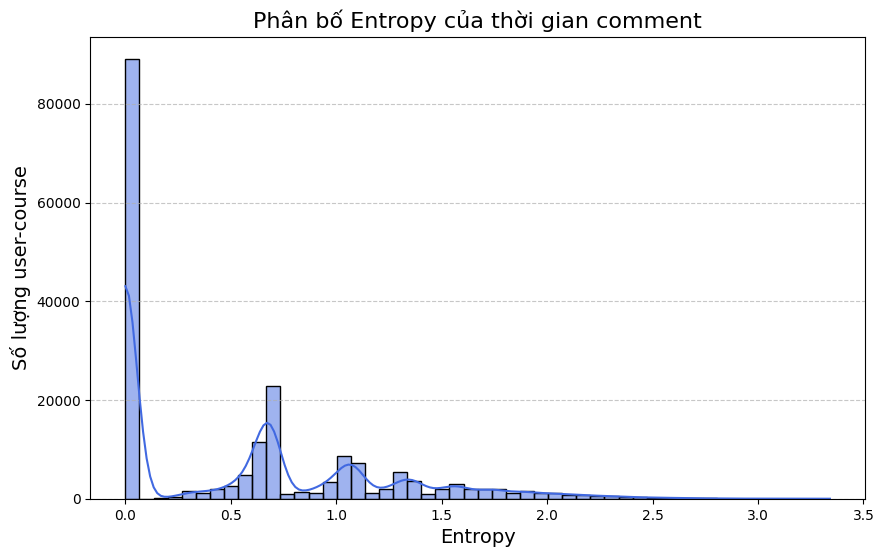

In [43]:
# Vẽ biểu đồ phân bố entropy
plt.figure(figsize=(10, 6))
sns.histplot(entropy_values_phase2["entropy_time_comment_phase2"], bins=50, kde=True, color="royalblue")

# Định dạng biểu đồ
plt.xlabel("Entropy", fontsize=14)
plt.ylabel("Số lượng user-course", fontsize=14)
plt.title("Phân bố Entropy của thời gian comment", fontsize=16)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Hiển thị biểu đồ
plt.show()

In [44]:
Phase2_comment = result_phase2.merge(entropy_values_phase2, on=['user_id', 'course_id'], how='outer')

# Nếu một số user-course không có entropy, điền giá trị mặc định là 0
Phase2_comment['entropy_time_comment_phase2'] = Phase2_comment['entropy_time_comment_phase2'].fillna(0)

print(Phase2_comment.head())

      user_id  course_id  comment_count_phase2  total_words_phase2  \
0   U_1001703   C_735164                     2                  39   
1   U_1002046   C_760442                     2                 196   
2   U_1003052  C_1750780                     2                  11   
3    U_100306   C_707083                     1                  11   
4  U_10030725   C_948141                     2                 326   

   entropy_time_comment_phase2  
0                     0.000000  
1                     0.000000  
2                     0.693147  
3                     0.000000  
4                     0.693147  


# Phase 3

In [45]:
Phase3_cmt = comment[(comment['days_since_enroll'] > 28) & (comment['days_since_enroll'] <= 42)]

Phase3_cmt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 751012 entries, 7221 to 6608549
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   comment_id         751012 non-null  object        
 1   user_id            751012 non-null  object        
 2   course_id          751012 non-null  object        
 3   text               751012 non-null  object        
 4   create_time        751012 non-null  datetime64[ns]
 5   enroll_time        751012 non-null  datetime64[ns]
 6   days_since_enroll  751012 non-null  int64         
 7   num_words_rep      751012 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 51.6+ MB


In [46]:
# Tính tổng số chữ phản hồi của user trong phase 3
word_count_phase3 = Phase3_cmt.groupby(['user_id', 'course_id'])['num_words_rep'].sum().reset_index(name='total_words_phase3')

# Đếm số lượng phản hồi trong phase 3
comment_count_phase3 = Phase3_cmt.groupby(['user_id', 'course_id']).size().reset_index(name='comment_count_phase3')

result_phase3 = pd.merge(comment_count_phase3, word_count_phase3, on=['user_id', 'course_id'], how='outer')
print(result_phase3)

          user_id  course_id  comment_count_phase3  total_words_phase3
0       U_1001883   C_682280                     4                  88
1       U_1002046   C_760442                     1                 146
2       U_1002784  C_1756056                     3                 119
3       U_1003052  C_1750780                     2                  84
4        U_100306   C_696972                     1                   4
...           ...        ...                   ...                 ...
136512   U_997054   C_735164                     4                 244
136513   U_997542  C_2066096                     2                 972
136514    U_99772  C_1903985                     3                 320
136515    U_99772   C_697038                     2                  80
136516   U_999111   C_760442                     1                 366

[136517 rows x 4 columns]


In [47]:
# Bước 1: Sắp xếp dữ liệu theo user_id, course_id, và create_time
Phase3_cmt = Phase3_cmt.sort_values(by=['user_id', 'course_id', 'create_time'])

# Bước 2: Xác định khoảng thời gian (bins)
Phase3_cmt['time_bin'] = Phase3_cmt['create_time'].apply(assign_time_bin)

# Bước 3: Đếm số lượng comment trong mỗi khoảng thời gian
time_bin_counts3 = Phase3_cmt.groupby(['user_id', 'course_id', 'time_bin']).size().reset_index(name='count')

# Bước 4: Tính tổng số comment của mỗi user trong từng khóa học
total_comments3 = Phase3_cmt.groupby(['user_id', 'course_id']).size().reset_index(name='total_count')

# Gộp dữ liệu để tính xác suất
time_bin_counts3 = time_bin_counts3.merge(total_comments3, on=['user_id', 'course_id'], how='left')

# Bước 5: Tính xác suất xuất hiện của mỗi bin
time_bin_counts3['probability'] = time_bin_counts3['count'] / time_bin_counts3['total_count']

# Bước 6: Tính entropy theo công thức Shannon entropy
entropy_values_phase3 = (
    time_bin_counts3.groupby(['user_id', 'course_id'])['probability']
    .apply(lambda x: calculate_entropy(x.values))
    .reset_index(name='entropy_time_comment_phase3')
)

# Hiển thị kết quả
print(entropy_values_phase3.head())

     user_id  course_id  entropy_time_comment_phase3
0  U_1001883   C_682280                     0.562335
1  U_1002046   C_760442                     0.000000
2  U_1002784  C_1756056                     1.098612
3  U_1003052  C_1750780                     0.000000
4   U_100306   C_696972                     0.000000


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


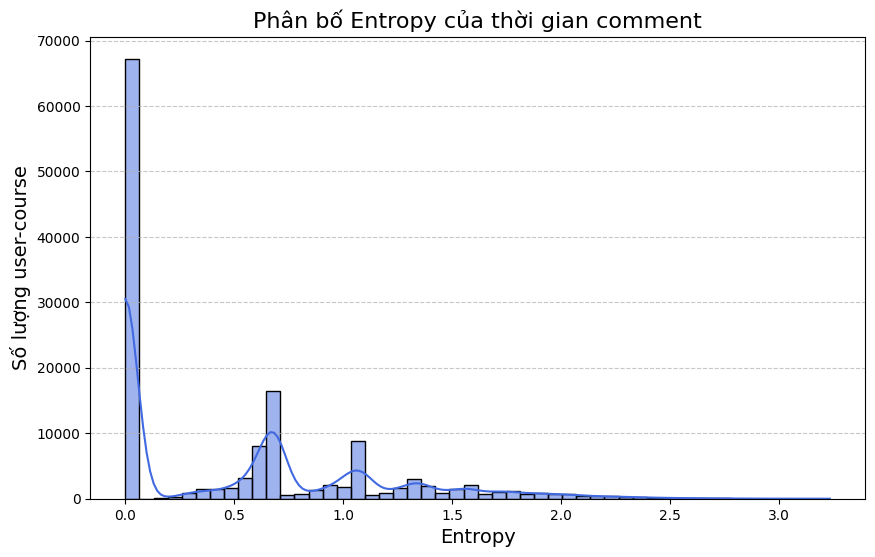

In [48]:
# Vẽ biểu đồ phân bố entropy
plt.figure(figsize=(10, 6))
sns.histplot(entropy_values_phase3["entropy_time_comment_phase3"], bins=50, kde=True, color="royalblue")

# Định dạng biểu đồ
plt.xlabel("Entropy", fontsize=14)
plt.ylabel("Số lượng user-course", fontsize=14)
plt.title("Phân bố Entropy của thời gian comment", fontsize=16)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Hiển thị biểu đồ
plt.show()

In [49]:
Phase3_comment = result_phase3.merge(entropy_values_phase3, on=['user_id', 'course_id'], how='outer')

# Nếu một số user-course không có entropy, điền giá trị mặc định là 0
Phase3_comment['entropy_time_comment_phase3'] = Phase3_comment['entropy_time_comment_phase3'].fillna(0)

print(Phase3_comment.head())

     user_id  course_id  comment_count_phase3  total_words_phase3  \
0  U_1001883   C_682280                     4                  88   
1  U_1002046   C_760442                     1                 146   
2  U_1002784  C_1756056                     3                 119   
3  U_1003052  C_1750780                     2                  84   
4   U_100306   C_696972                     1                   4   

   entropy_time_comment_phase3  
0                     0.562335  
1                     0.000000  
2                     1.098612  
3                     0.000000  
4                     0.000000  


# Phase 4

In [50]:
Phase4_cmt = comment[(comment['days_since_enroll'] > 42) & (comment['days_since_enroll'] <= 56)]

Phase4_cmt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 498160 entries, 16500 to 6608555
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   comment_id         498160 non-null  object        
 1   user_id            498160 non-null  object        
 2   course_id          498160 non-null  object        
 3   text               498160 non-null  object        
 4   create_time        498160 non-null  datetime64[ns]
 5   enroll_time        498160 non-null  datetime64[ns]
 6   days_since_enroll  498160 non-null  int64         
 7   num_words_rep      498160 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 34.2+ MB


In [51]:
# Tính tổng số chữ phản hồi của user trong phase 4
word_count_phase4 = Phase4_cmt.groupby(['user_id', 'course_id'])['num_words_rep'].sum().reset_index(name='total_words_phase4')

# Đếm số lượng phản hồi trong phase 4
comment_count_phase4 = Phase4_cmt.groupby(['user_id', 'course_id']).size().reset_index(name='comment_count_phase4')

result_phase4 = pd.merge(comment_count_phase4, word_count_phase4, on=['user_id', 'course_id'], how='outer')
print(result_phase4)

# Bước 1: Sắp xếp dữ liệu theo user_id, course_id, và create_time
Phase4_cmt = Phase4_cmt.sort_values(by=['user_id', 'course_id', 'create_time'])

# Bước 2: Xác định khoảng thời gian (bins)
Phase4_cmt['time_bin'] = Phase4_cmt['create_time'].apply(assign_time_bin)

# Bước 3: Đếm số lượng comment trong mỗi khoảng thời gian
time_bin_counts4 = Phase4_cmt.groupby(['user_id', 'course_id', 'time_bin']).size().reset_index(name='count')

# Bước 4: Tính tổng số comment của mỗi user trong từng khóa học
total_comments4 = Phase4_cmt.groupby(['user_id', 'course_id']).size().reset_index(name='total_count')

# Gộp dữ liệu để tính xác suất
time_bin_counts4 = time_bin_counts4.merge(total_comments4, on=['user_id', 'course_id'], how='left')

# Bước 5: Tính xác suất xuất hiện của mỗi bin
time_bin_counts4['probability'] = time_bin_counts4['count'] / time_bin_counts4['total_count']

# Bước 6: Tính entropy theo công thức Shannon entropy
entropy_values_phase4 = (
    time_bin_counts4.groupby(['user_id', 'course_id'])['probability']
    .apply(lambda x: calculate_entropy(x.values))
    .reset_index(name='entropy_time_comment_phase4')
)

# Hiển thị kết quả
print(entropy_values_phase4.head())

          user_id  course_id  comment_count_phase4  total_words_phase4
0       U_1001314  C_1779421                     2                 192
1       U_1002046   C_735164                     3                  56
2        U_100306   C_696972                     2                   3
3      U_10031007   C_936971                     3                  29
4      U_10031670   C_911162                     1                  46
...           ...        ...                   ...                 ...
92558   U_9968551   C_697307                     2                  79
92559   U_9968880   C_936971                     2                  22
92560   U_9969645   C_881314                     1                 339
92561    U_997012   C_694149                     1                  17
92562    U_999111   C_735164                     1                   5

[92563 rows x 4 columns]
      user_id  course_id  entropy_time_comment_phase4
0   U_1001314  C_1779421                     0.000000
1   U_1002046 

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


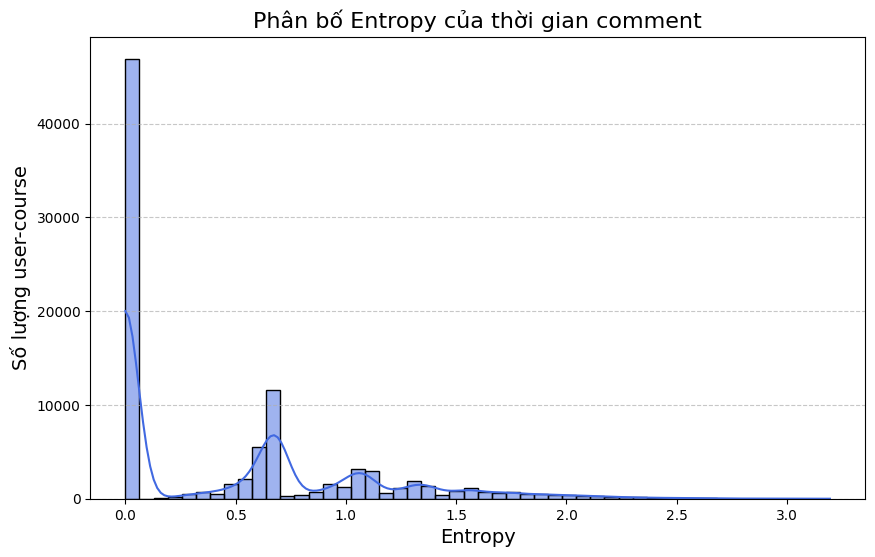

In [52]:
# Vẽ biểu đồ phân bố entropy
plt.figure(figsize=(10, 6))
sns.histplot(entropy_values_phase4["entropy_time_comment_phase4"], bins=50, kde=True, color="royalblue")

# Định dạng biểu đồ
plt.xlabel("Entropy", fontsize=14)
plt.ylabel("Số lượng user-course", fontsize=14)
plt.title("Phân bố Entropy của thời gian comment", fontsize=16)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Hiển thị biểu đồ
plt.show()

In [53]:
Phase4_comment = result_phase4.merge(entropy_values_phase4, on=['user_id', 'course_id'], how='outer')

# Nếu một số user-course không có entropy, điền giá trị mặc định là 0
Phase4_comment['entropy_time_comment_phase4'] = Phase4_comment['entropy_time_comment_phase4'].fillna(0)

print(Phase4_comment.head())

      user_id  course_id  comment_count_phase4  total_words_phase4  \
0   U_1001314  C_1779421                     2                 192   
1   U_1002046   C_735164                     3                  56   
2    U_100306   C_696972                     2                   3   
3  U_10031007   C_936971                     3                  29   
4  U_10031670   C_911162                     1                  46   

   entropy_time_comment_phase4  
0                     0.000000  
1                     0.000000  
2                     0.693147  
3                     0.000000  
4                     0.000000  


In [54]:
# Gộp dữ liệu của các phase lại
Phase2 = Phase2_comment.merge(Phase1_comment, on=['user_id', 'course_id'], how='outer')

Phase3 = Phase3_comment.merge(Phase2, on=['user_id', 'course_id'], how='outer')

all_phases_comment = Phase4_comment.merge(Phase3, on=['user_id', 'course_id'], how='outer')

new_column_order = [
    'user_id', 
    'course_id', 
    'comment_count_phase1', 
    'total_words_phase1', 
    'entropy_time_comment_phase1', 
    'comment_count_phase2', 
    'total_words_phase2', 
    'entropy_time_comment_phase2', 
    'comment_count_phase3', 
    'total_words_phase3', 
    'entropy_time_comment_phase3', 
    'comment_count_phase4', 
    'total_words_phase4', 
    'entropy_time_comment_phase4'
]

# Sắp xếp lại thứ tự cột trong DataFrame
all_phases_comment = all_phases_comment[new_column_order]

all_phases_comment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646883 entries, 0 to 646882
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   user_id                      646883 non-null  object 
 1   course_id                    646883 non-null  object 
 2   comment_count_phase1         488015 non-null  float64
 3   total_words_phase1           488015 non-null  float64
 4   entropy_time_comment_phase1  488015 non-null  float64
 5   comment_count_phase2         191627 non-null  float64
 6   total_words_phase2           191627 non-null  float64
 7   entropy_time_comment_phase2  191627 non-null  float64
 8   comment_count_phase3         136517 non-null  float64
 9   total_words_phase3           136517 non-null  float64
 10  entropy_time_comment_phase3  136517 non-null  float64
 11  comment_count_phase4         92563 non-null   float64
 12  total_words_phase4           92563 non-null   float64
 13 

In [55]:
all_phases_comment.head(10)

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,user_id,course_id,comment_count_phase1,total_words_phase1,entropy_time_comment_phase1,comment_count_phase2,total_words_phase2,entropy_time_comment_phase2,comment_count_phase3,total_words_phase3,entropy_time_comment_phase3,comment_count_phase4,total_words_phase4,entropy_time_comment_phase4
0,U_1000902,C_697821,1.0,2.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,U_1001314,C_1779421,3.0,43.0,0.636514,NaN,NaN,NaN,NaN,NaN,NaN,2.0,192.0,0.0
2,U_10015,C_1729417,1.0,8.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,U_1001600,C_694149,1.0,2.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,U_1001625,C_735164,1.0,8.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,U_1001703,C_735164,2.0,2.0,0.693147,2.0,39.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
6,U_1001806,C_1903976,1.0,5.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,U_1001875,C_926175,14.0,1410.0,1.331664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,U_1001883,C_682280,NaN,NaN,NaN,NaN,NaN,NaN,4.0,88.0,0.562335,NaN,NaN,NaN
9,U_1002046,C_735164,1.0,47.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,3.0,56.0,0.0
